In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd "/content/gdrive/MyDrive/ARDF_SSD"

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1qYHA6AgfkviPjK9bxK3OfHqP1cktD-Up/ARDF_SSD


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install rdkit pubchempy pyxlsb xlrd -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 54.1 MB/s eta 0:00:00


# Data Curation Workflow (To Replace Knime)

1. Reading Molecules from SMILES:

    - This step ensures that you correctly read the molecules into RDKit's Mol objects from the SMILES strings.

2. Removing Mixtures:

    - This step ensures that only single-component molecules are considered, as mixtures can complicate analysis.

3. Removing Salts:

    - Removing salts ensures that only the main chemical component is considered, which is crucial for consistency in descriptor generation.
Removing Inorganic and

4. Organometallic Compounds:

    - This step ensures that only organic molecules are retained, which is usually relevant for SSD modeling.

5. Geometric Optimization:

    - Optimizing the geometry of molecules using methods like ETKDG and UFF ensures that you have a reasonable 3D structure for each molecule, which can be important for accurate descriptor calculation.

6. Normalization:

    - Simplified normalization by removing hydrogens helps in standardizing the molecules for descriptor generation.

7. Adding Hydrogens:

    - Adding hydrogens can be essential for certain types of descriptor calculations that require explicit hydrogen atoms.

8. Generating SDF File:

    - Saving the curated molecules to an SDF file ensures that the cleaned and standardized molecules are stored in a commonly used chemical format for further analysis.

- https://cactus.nci.nih.gov/translate/

Based on the two papers, the chemical curation workflow involves a series of systematic steps designed to clean and standardize chemical data for use in cheminformatics and QSAR modeling. Here’s a summary of the workflow and tools recommended in both papers:

### **Chemical Curation Workflow**

1. **Initial Data Cleaning**
   - **Objective**: Remove irrelevant or unsuitable data (e.g., inorganics, mixtures, and non-standard compounds).
   - **Steps**:
     - **Remove Inorganics and Mixtures**: Identify and exclude compounds that are inorganic or mixtures, as these are generally not suitable for QSAR modeling.
     - **Tool**: ChemAxon’s JChem or Standardizer.

2. **Structural Normalization**
   - **Objective**: Ensure consistency across the dataset by standardizing chemical structures.
   - **Steps**:
     - **Normalize Functional Groups**: Convert different representations of the same functional group to a standard form.
     - **Aromatize Rings**: Ensure that aromatic rings are consistently represented.
     - **Correct Common Structural Anomalies**: Fix issues like incorrect stereochemistry or bond types.
     - **Tool**: ChemAxon’s Standardizer.

3. **Duplicate Removal**
   - **Objective**: Identify and remove duplicate structures to avoid bias in modeling.
   - **Steps**:
     - **Detect Duplicates**: Use structural descriptors to identify duplicates.
     - **Handle Duplicates with Different Bioactivities**: Special consideration is given to cases where duplicates have different reported bioactivities.
     - **Tool**: ISIDA/Duplicates, HiT QSAR.

4. **Tautomer and Isomer Curation**
   - **Objective**: Manage different tautomeric or isomeric forms to ensure data consistency.
   - **Steps**:
     - **Detect and Standardize Tautomers/Isomers**: Use software to recognize and standardize tautomers and isomers.
     - **Tool**: Manual inspection or specialized software (e.g., ChemAxon’s tautomer tools).

5. **Manual Inspection**
   - **Objective**: Ensure that automated processes have not missed any significant errors.
   - **Steps**:
     - **Review Chemical Structures**: Manually inspect a representative sample of the dataset, focusing on complex or high-value compounds.
     - **Tool**: Manual curation using cheminformatics software.

6. **Final Review and Validation**
   - **Objective**: Validate the curated dataset before proceeding to modeling.
   - **Steps**:
     - **Re-run Duplicate Searches**: Ensure no duplicates remain after curation.
     - **Validate Against External Databases**: Compare the curated dataset with external databases or literature to confirm accuracy.
     - **Tool**: OpenBabel for format conversion and structure validation.

### **Tools Recommended**

1. **ChemAxon’s Standardizer**:
   - Used for structural normalization, including functional group standardization, aromatization, and fixing common structural errors.

2. **ISIDA/Duplicates**:
   - A tool for detecting duplicates based on structural similarities, useful for cleaning datasets.

3. **HiT QSAR**:
   - A software tool for identifying duplicates based on atom connectivity, which helps in maintaining a unique set of structures.

4. **OpenBabel**:
   - A versatile tool for file format conversion, structure processing, and additional structure validation steps.

5. **ChemAxon’s JChem**:
   - Useful for initial data cleaning, particularly in removing inorganics and mixtures from large datasets.

### **Additions in the Second Paper**
- **Activity Cliffs Handling**: Identifying and managing situations where small structural changes lead to significant differences in activity.
- **Bioactivity Data Integration**: Steps to curate and integrate chemical and bioactivity data, addressing discrepancies and experimental variability.
- **Modelability Index (MODI)**: A new concept introduced to assess the feasibility of developing predictive models from curated datasets.

### **Summary**
The chemical curation workflow outlined in these papers is designed to systematically clean, standardize, and validate chemical datasets to ensure their suitability for cheminformatics and QSAR modeling. The process involves removing irrelevant data, normalizing structures, eliminating duplicates, and conducting thorough manual inspections. Tools like ChemAxon’s Standardizer, ISIDA/Duplicates, and OpenBabel play a critical role in automating and enhancing the curation process. The second paper expands the workflow by integrating bioactivity data curation and introducing new concepts like activity cliffs and modelability indices, making the curation process more comprehensive.

In [ ]:
# %%writefile "Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Code/2.Chemical_Curation_Workflow.py"
# Executin started 12:50
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors  # Add this line
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import requests
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, and counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'InChIKey' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchikey_smiles_map = {}
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        Organic compounds must contain carbon and at least one other element, and should not contain metals or counterions.
        """
        def is_organic(smiles):
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            # Check for the presence of metals (organometallics) or the absence of carbon
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True

        def is_counterion(smiles):
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # Identify small molecules or ions typically used as counterions (e.g., Na+, Cl-)
            return Descriptors.MolWt(mol) < 100  # Example threshold for small ions

        unique_inchikeys = self.df['InChIKey'].unique()
        logging.info("Processing %d unique InChIKeys to remove inorganics, organometallics, counterions, biologics, and mixtures.", len(unique_inchikeys))

        for inchikey in unique_inchikeys:
            smiles = self.inchikey_to_smiles(inchikey)
            if smiles and is_organic(smiles) and not is_counterion(smiles):
                self.inchikey_smiles_map[inchikey] = smiles

        # Map the InChIKeys to their corresponding SMILES and filter out inorganics/mixtures
        self.df['SMILES'] = self.df['InChIKey'].map(self.inchikey_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['SMILES']).copy()
        logging.info("Removed inorganics, organometallics, counterions, biologics, and mixtures. Cleaned data shape: %s", self.cleaned_data.shape)

    def inchikey_to_smiles(self, inchikey):
        """
        Convert an InChIKey to SMILES by querying an external chemical database.

        Args:
            inchikey (str): The InChIKey to convert.

        Returns:
            str: The corresponding SMILES string, or None if retrieval fails.
        """
        try:
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/CanonicalSMILES/TXT'
            response = requests.get(url)
            response.raise_for_status()
            smiles = response.text.strip()
            logging.info("Retrieved SMILES for InChIKey %s", inchikey)
            return smiles
        except Exception as e:
            logging.error("Failed to retrieve SMILES for InChIKey %s: %s", inchikey, e)
            return None

    def normalize_structures(self):
        """
        Normalize chemical structures by sanitizing molecules and preserving aromaticity.
        """
        def normalize_smiles(smiles):
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            Chem.SanitizeMol(mol)  # Ensure the molecule is clean
            # Skip Kekulization to preserve aromaticity
            return Chem.MolToSmiles(mol, kekuleSmiles=False)

        self.cleaned_data['Normalized SMILES'] = self.cleaned_data['SMILES'].apply(normalize_smiles)
        logging.info("Normalized chemical structures. Data shape after normalization: %s", self.cleaned_data.shape)

    def handle_tautomers_and_isomers(self):
        """
        Detect and standardize tautomers and isomers using RDKit's MolStandardize.
        """
        def standardize_tautomer(smiles):
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None
                enumerator = rdMolStandardize.TautomerEnumerator()
                tautomer = enumerator.Canonicalize(mol)
                return Chem.MolToSmiles(tautomer)
            except Exception as e:
                logging.error("Failed to standardize tautomer for SMILES %s: %s", smiles, e)
                return None

        def handle_isomers(smiles):
            """
            Handle stereoisomers by generating canonical SMILES that include stereochemistry.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None
                # Generate the canonical SMILES with stereochemistry included
                return Chem.MolToSmiles(mol, isomericSmiles=True)
            except Exception as e:
                logging.error("Failed to handle isomer for SMILES %s: %s", smiles, e)
                return None

        # Standardize tautomers first
        self.cleaned_data['Standardized SMILES'] = self.cleaned_data['Normalized SMILES'].apply(standardize_tautomer)
        logging.info("Standardized tautomers. Data shape after tautomer standardization: %s", self.cleaned_data.shape)

        # Then handle stereoisomers
        self.cleaned_data['Isomeric SMILES'] = self.cleaned_data['Standardized SMILES'].apply(handle_isomers)
        logging.info("Handled isomers. Data shape after isomer handling: %s", self.cleaned_data.shape)

    def validate_and_finalize(self):
        """
        Final validation of the curated dataset, including:
        - Removing duplicate SMILES.
        - Ensuring all SMILES strings are valid.
        - Cross-referencing with external databases.
        """
        # Re-check for duplicates after standardization and isomer handling
        self.cleaned_data.drop_duplicates(subset=['Isomeric SMILES'], inplace=True)

        # Validate that all SMILES are valid molecules
        def is_valid_smiles(smiles):
            return Chem.MolFromSmiles(smiles) is not None

        self.cleaned_data = self.cleaned_data[self.cleaned_data['Isomeric SMILES'].apply(is_valid_smiles)]

        # Cross-reference with external databases (e.g., PubChem) for additional validation
        def cross_reference_smiles(smiles):
            try:
                url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/TXT'
                response = requests.get(url)
                return response.status_code == 200
            except:
                return False

        self.cleaned_data = self.cleaned_data[self.cleaned_data['Isomeric SMILES'].apply(cross_reference_smiles)]
        logging.info("Final validation complete. Total valid entries: %d", len(self.cleaned_data))

    def curate_data(self):
        """
        Run the full curation workflow on the DataFrame.

        Returns:
            pandas.DataFrame: The curated chemical data.
        """
        logging.info("Starting data curation process.")
        # Step 1: Initial Data Cleaning
        self.remove_inorganics_and_mixtures()

        # Step 2: Structural Normalization
        self.normalize_structures()

        # Step 3: Handle Tautomers and Isomers
        self.handle_tautomers_and_isomers()

        # Step 4: Final Review and Validation
        self.validate_and_finalize()

        logging.info("Data curation process completed.")
        return self.cleaned_data

    def generate_sdf(self, output_file):
        """
        Generate an SDF file from the curated SMILES data.

        Args:
            output_file (str): The path to the output SDF file.
        """
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Isomeric SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    # Load the input DataFrame from a CSV file
    df_with_inchikey = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIKeyRetrieved.csv')

    # Create an instance of the ChemicalCuration class
    curator = ChemicalCuration(df_with_inchikey)

    # Run the data curation process
    curated_df = curator.curate_data()

    # Save the curated DataFrame to a CSV file
    curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)

    # Generate an SDF file from the curated data
    curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')

[10:20:03] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:03] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:04] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:04] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:04] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:05] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:05] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:05] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:06] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:06] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:06] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:07] Tautomer enumeration stopped at 238 tautomers: max transforms reached
[10:20:07] Tautomer enumerat

In [ ]:
len(df_with_smiles_and_inchikey), df_with_smiles_and_inchikey['Curated_SMILES'].value_counts().sum()

(117623, 114793)

In [ ]:
# Number of Unique SMILES
len(df_with_smiles_and_inchikey['SMILES'].unique())

2809

In [ ]:
# Number of Curated SMILES
len(df_with_smiles_and_inchikey[~df_with_smiles_and_inchikey['Curated_SMILES'].isnull()]['SMILES'].unique())

2191

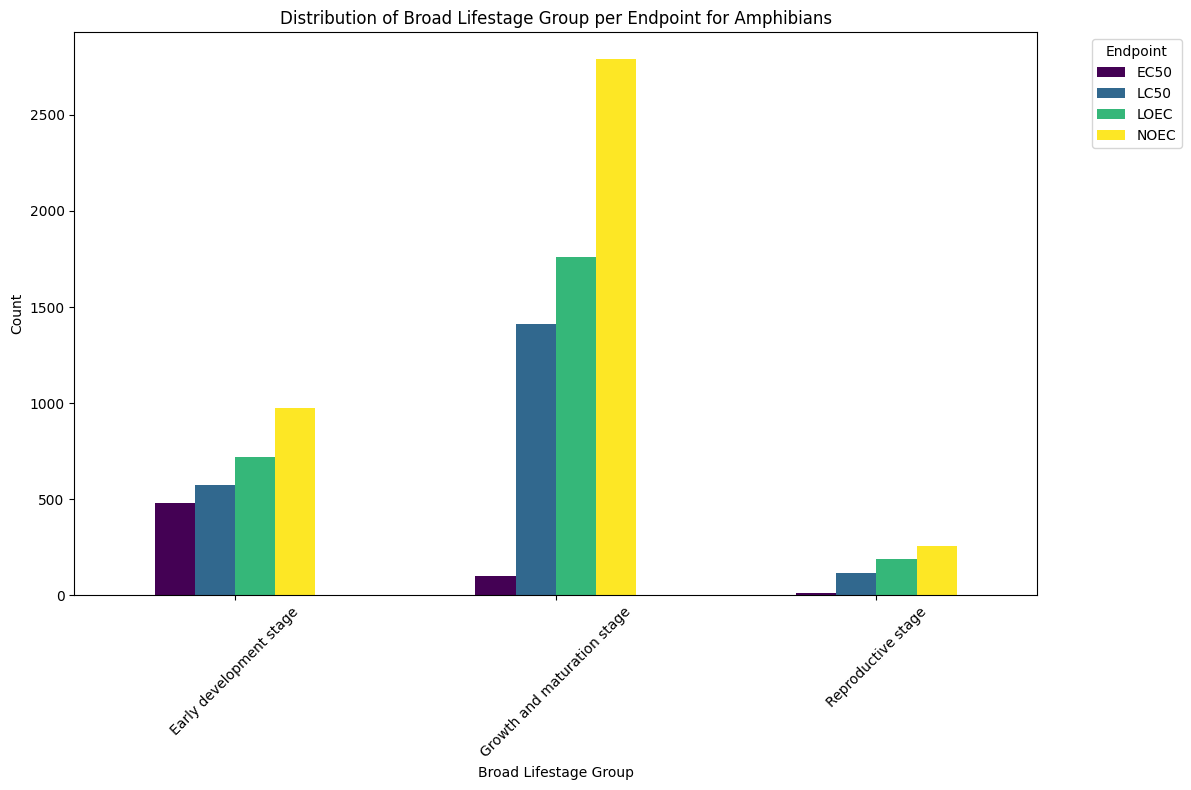

Data Distribution for Amphibians:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       481   576   722   973
Growth and maturation stage   101  1411  1762  2790
Reproductive stage             14   116   188   257 



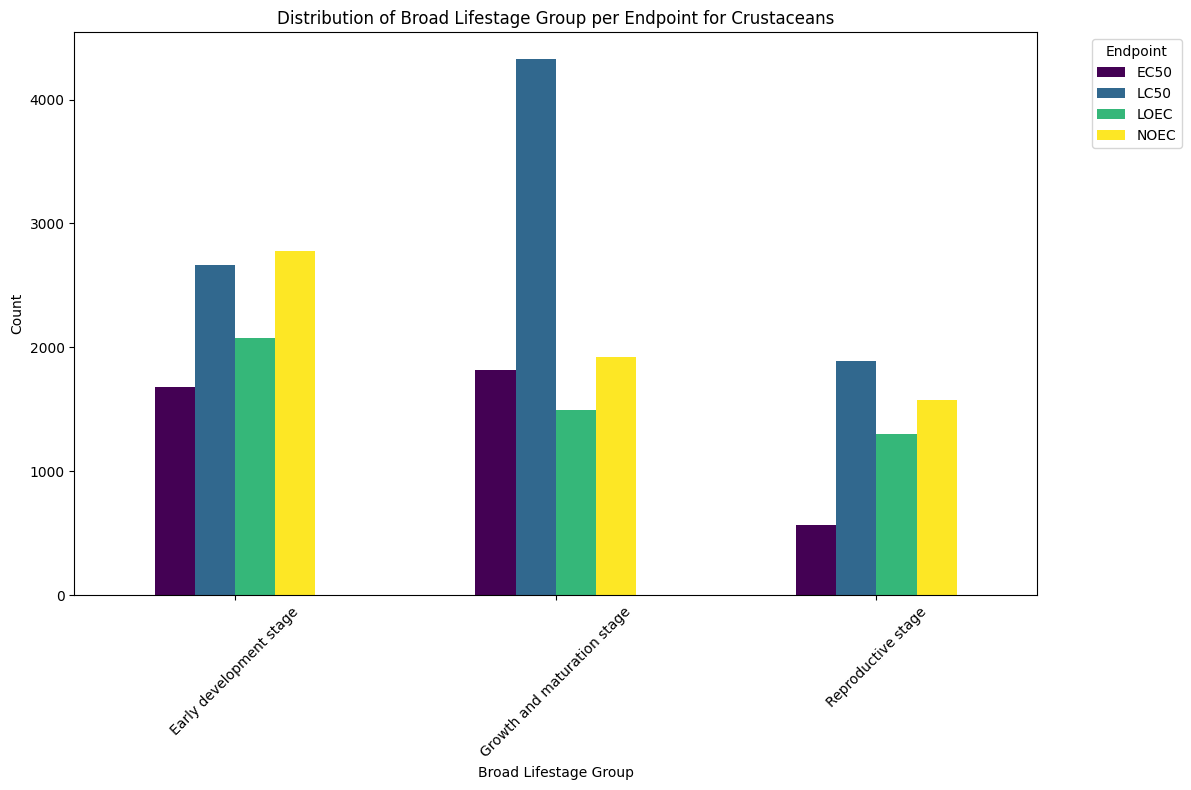

Data Distribution for Crustaceans:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage      1677  2665  2073  2776
Growth and maturation stage  1818  4326  1495  1920
Reproductive stage            569  1892  1301  1578 



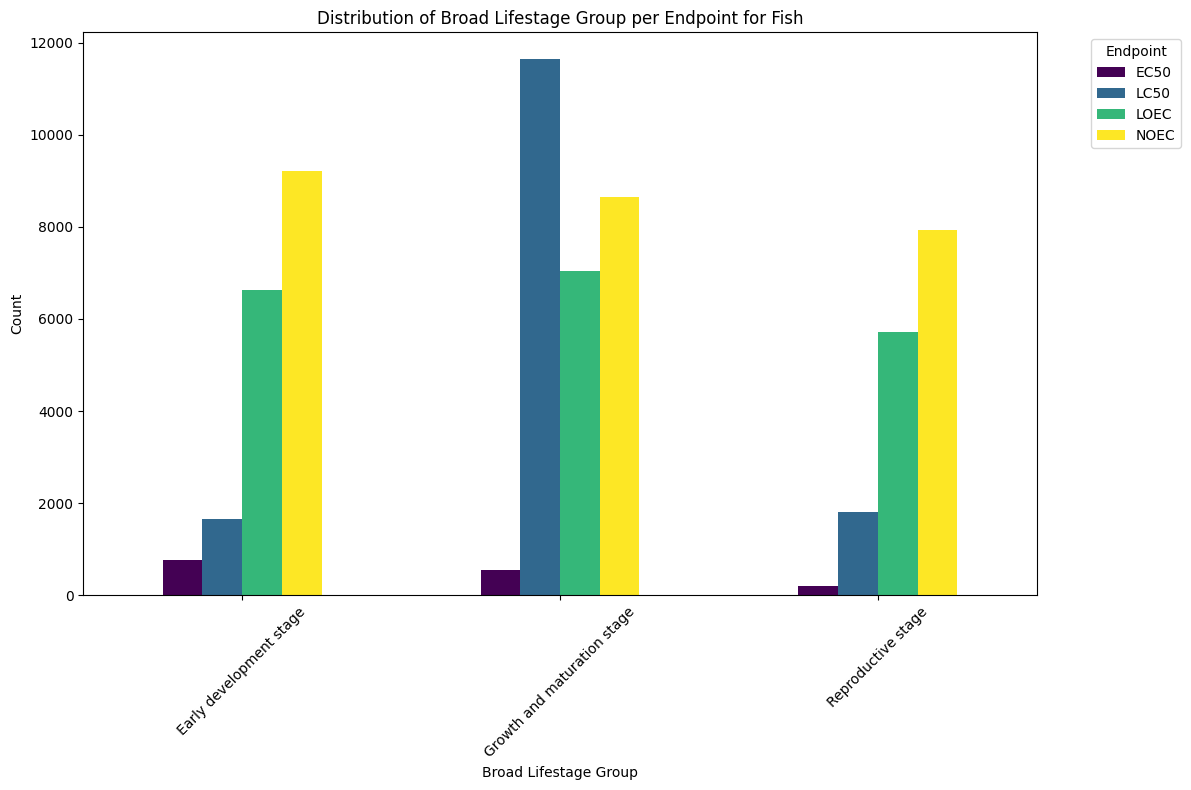

Data Distribution for Fish:
Endpoint                     EC50   LC50  LOEC  NOEC
Broad Lifestage Group                               
Early development stage       763   1660  6627  9204
Growth and maturation stage   542  11641  7045  8644
Reproductive stage            194   1813  5710  7939 



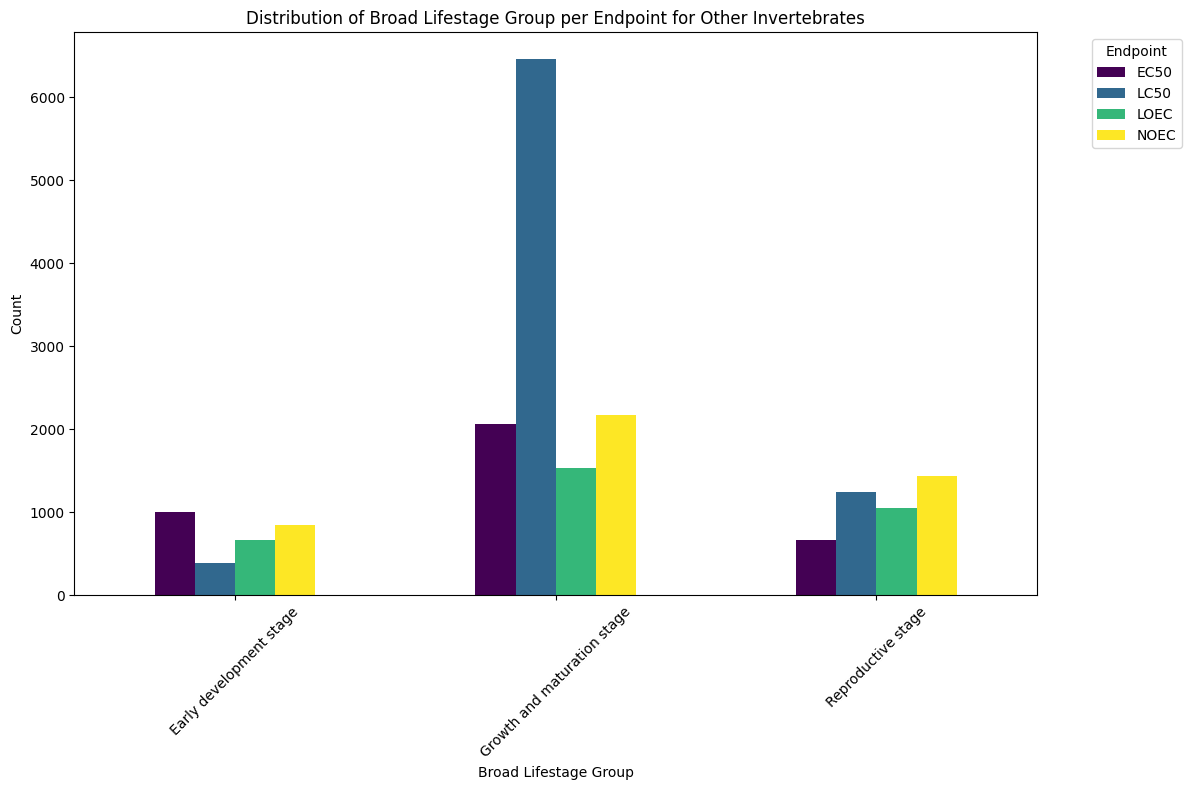

Data Distribution for Other Invertebrates:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       999   389   667   850
Growth and maturation stage  2066  6456  1539  2172
Reproductive stage            662  1250  1049  1431 



In [ ]:
curated_df = df_with_smiles_and_inchikey[~df_with_smiles_and_inchikey['Curated_SMILES'].isnull()]

# Get unique species from the 'Species Group' column
species_groups = curated_df['Species Group'].unique()

# Create an empty dictionary to store DataFrame for each species
species_pivot_tables = {}

for species in species_groups:
    # Filter DataFrame for the current species
    df_species = curated_df[curated_df['Species Group'] == species]

    # Group by 'Endpoint' and 'Broad Lifestage Group' and count the occurrences
    endpoint_lifestage_counts = df_species.groupby(['Endpoint', 'Broad Lifestage Group']).size()

    # Reset the index to turn the results into a DataFrame
    endpoint_lifestage_counts_df = endpoint_lifestage_counts.reset_index(name='Count')

    # Pivot the DataFrame to get 'Broad Lifestage Group' as rows, 'Endpoint' as columns, and 'Count' as cell values
    pivoted_df = endpoint_lifestage_counts_df.pivot(index='Broad Lifestage Group', columns='Endpoint', values='Count').fillna(0)

    if len(pivoted_df) > 0:
        # Store the pivoted DataFrame in the dictionary using the species name as the key
        species_pivot_tables[species] = pivoted_df

        # Plotting the data for the current species
        pivoted_df.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

        # Customizing the plot
        plt.title(f'Distribution of Broad Lifestage Group per Endpoint for {species}')
        plt.xlabel('Broad Lifestage Group')
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate labels to improve readability
        plt.legend(title='Endpoint', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show and save the plot
        plt.tight_layout()
        plt.savefig(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Figures/LifeStageData_curated_distribution_{species}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Optionally print the pivoted DataFrame
        print(f"Data Distribution for {species}:")
        print(pivoted_df, "\n")
        pivoted_df.to_csv(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Stats/LifeStageData_curated_distribution_{species}.csv')

In [ ]:
curated_df.to_csv("Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv", index=False)

# Properties & Descriptors & Fingerprints Retrieval and Curation


In [ ]:
import pandas as pd

curated_df = pd.read_csv("Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv")

In [ ]:
curated_df = curated_df[~curated_df['Curated_SMILES'].isna()]

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from io import StringIO
import logging
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

class CompoundDataProcessor:
    def __init__(self):
        self.opera_url = "https://opera.saferworldbydesign.com/opera/global-descriptors"
        self.pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"
        self.properties = "MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,InChIKey,IUPACName,Title,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount,PatentCount,PatentFamilyCount,LiteratureCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,Fingerprint2D"

    @lru_cache(maxsize=128)  # Simple cache to avoid redundant API calls
    def inchi_to_smiles(self, inchi):
        mol = Chem.MolFromInchi(inchi)
        return Chem.MolToSmiles(mol) if mol else None

    @lru_cache(maxsize=128)
    def get_opera_data(self, identifier, identifier_type='smiles'):
        rename_dict = {
            "AD_FUB": "Fraction Unbound",
            "AD_LogD": "LogD",
            "AD_LogP": "LogP",
            "AD_MP": "Melting Point",
            "AD_VP": "Vapor Pressure",
            "AD_WS": "Water Solubility",
            "AD_index_FUB": "Fraction Unbound Index",
            "AD_index_LogD": "LogD Index",
            "AD_index_LogP": "LogP Index",
            "AD_index_MP": "Melting Point Index",
            "AD_index_VP": "Vapor Pressure Index",
            "AD_index_WS": "Water Solubility Index",
            "AD_index_pKa": "pKa Index",
            "AD_pKa": "pKa",
            "CombDipolPolariz": "Combined Dipole Polarizability",
            "Conf_index_FUB": "Confidence Fraction Unbound",
            "Conf_index_LogD": "Confidence LogD",
            "Conf_index_LogP": "Confidence LogP",
            "Conf_index_MP": "Confidence Melting Point",
            "Conf_index_VP": "Confidence Vapor Pressure",
            "Conf_index_WS": "Confidence Water Solubility",
            "Conf_index_pKa": "Confidence pKa",
            "FUB_pred": "Predicted Fraction Unbound",
            "FUB_predRange": "Predicted Fraction Unbound Range",
            "LogD55_pred": "Predicted LogD at pH 5.5",
            "LogD55_predRange": "Predicted LogD at pH 5.5 Range",
            "LogD74_pred": "Predicted LogD at pH 7.4",
            "LogD74_predRange": "Predicted LogD at pH 7.4 Range",
            "LogP_pred": "Predicted LogP",
            "LogP_predRange": "Predicted LogP Range",
            "LogVP_pred": "Predicted Vapor Pressure",
            "LogWS_pred": "Predicted Water Solubility",
            "MP_pred": "Predicted Melting Point",
            "MP_predRange": "Predicted Melting Point Range",
            "MolWeight": "Molecular Weight",
            "MolarRefract": "Molar Refractivity",
            "Sp3Sp2HybRatio": "SP3 SP2 Hybridization Ratio",
            "TopoPolSurfAir": "Topological Polar Surface Area",
            "VP_predRange": "Predicted Vapor Pressure Range",
            "WS_predRange": "Predicted Water Solubility Range",
            "ionization": "Ionization Potential",
            "nbAromAtom": "Number Aromatic Atoms",
            "nbAtoms": "Number Atoms",
            "nbC": "Number Carbon Atoms",
            "nbHBdAcc": "Number HBond Acceptors",
            "nbHeavyAtoms": "Number Heavy Atoms",
            "nbHeteroRing": "Number Heterocyclic Rings",
            "nbLipinskiFailures": "Number Lipinski Rule Failures",
            "nbN": "Number Nitrogen Atoms",
            "nbO": "Number Oxygen Atoms",
            "nbRing": "Number Rings",
            "nbRotBd": "Number Rotatable Bonds",
            "ndHBdDon": "Number HBond Donors",
            "pKa_a_pred": "Predicted Acidic pKa",
            "pKa_a_predRange": "Predicted Acidic pKa Range",
            "pKa_b_pred": "Predicted Basic pKa",
            "pKa_b_predRange": "Predicted Basic pKa Range"
        }

        headers = {"Content-Type": "application/json"}
        data_key = "smiles" if identifier_type == 'smiles' else "inChI"
        response = requests.post(self.opera_url, json={data_key: identifier}, headers=headers)
        props = {}

        if response.status_code == 200:
            data = response.json()
            if 'data' in data and identifier in data['data']:
                raw_props = data['data'][identifier]
                # Rename the properties using the dictionary
                for prop, value in raw_props.items():
                    if prop in rename_dict:
                        new_key = rename_dict[prop]  # Use new names from dictionary
                        props[new_key] = value
                    else:
                        props[prop] = value
        return props


    @lru_cache(maxsize=128)
    def fetch_pubchem_properties(self, identifier, identifier_type='smiles'):
        pubchem_rename_dict = {
            "MolecularFormula": "Molecular Formula",
            "MolecularWeight": "Molecular Weight",
            "CanonicalSMILES": "Canonical SMILES",
            "IsomericSMILES": "Isomeric SMILES",
            "InChI": "InChI",
            "InChIKey": "InChI Key",
            "IUPACName": "IUPAC Name",
            "Title": "Title",
            "XLogP": "XLogP",
            "ExactMass": "Exact Mass",
            "MonoisotopicMass": "Monoisotopic Mass",
            "TPSA": "Topological Polar Surface Area",
            "Complexity": "Complexity",
            "Charge": "Charge",
            "HBondDonorCount": "HBond Donor Count",
            "HBondAcceptorCount": "HBond Acceptor Count",
            "RotatableBondCount": "Rotatable Bond Count",
            "HeavyAtomCount": "Heavy Atom Count",
            "IsotopeAtomCount": "Isotope Atom Count",
            "AtomStereoCount": "Atom Stereo Count",
            "DefinedAtomStereoCount": "Defined Atom Stereo Count",
            "UndefinedAtomStereoCount": "Undefined Atom Stereo Count",
            "BondStereoCount": "Bond Stereo Count",
            "DefinedBondStereoCount": "Defined Bond Stereo Count",
            "UndefinedBondStereoCount": "Undefined Bond Stereo Count",
            "CovalentUnitCount": "Covalent Unit Count",
            "Volume3D": "Volume 3D",
            "XStericQuadrupole3D": "X Steric Quadrupole 3D",
            "YStericQuadrupole3D": "Y Steric Quadrupole 3D",
            "ZStericQuadrupole3D": "Z Steric Quadrupole 3D",
            "FeatureCount3D": "Feature Count 3D",
            "FeatureAcceptorCount3D": "Feature Acceptor Count 3D",
            "FeatureDonorCount3D": "Feature Donor Count 3D",
            "FeatureAnionCount3D": "Feature Anion Count 3D",
            "FeatureCationCount3D": "Feature Cation Count 3D",
            "FeatureRingCount3D": "Feature Ring Count 3D",
            "FeatureHydrophobeCount3D": "Feature Hydrophobe Count 3D",
            "ConformerModelRMSD3D": "Conformer Model RMSD 3D",
            "EffectiveRotorCount3D": "Effective Rotor Count 3D",
            "ConformerCount3D": "Conformer Count 3D"
        }

        url = f"{self.pubchem_base_url}/{identifier_type}/{identifier}/property/{self.properties}/CSV"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = pd.read_csv(StringIO(response.text), sep=',')
            # Rename columns according to the dictionary
            data.rename(columns=pubchem_rename_dict, inplace=True)
            return data
        except Exception as e:
            logger.error(f"Error fetching properties for {identifier_type.upper()} {identifier}: {e}")
            return pd.DataFrame()


    def process_dataframe(self, df, column_name, identifier_type='smiles'):
        if identifier_type == 'inchi':
            df['SMILES'] = df[column_name].apply(self.inchi_to_smiles)
            column_name = 'SMILES'
            identifier_type = 'smiles'

        with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust max_workers based on your system's capabilities
            futures = {executor.submit(self.process_row, row, column_name, identifier_type): index for index, row in df.iterrows()}
            for future in futures:
                index = futures[future]
                try:
                    df.loc[index, future.result().keys()] = future.result().values()
                except Exception as e:
                    logger.error(f"Failed to process row {index}: {e}")

        return df

    def process_row(self, row, column_name, identifier_type):
        props = {}
        if pd.notna(row[column_name]):
            opera_props = self.get_opera_data(row[column_name], identifier_type)
            pubchem_props = self.fetch_pubchem_properties(row[column_name], identifier_type)
            props.update(opera_props)
            props.update(pubchem_props.iloc[0].to_dict() if not pubchem_props.empty else {})
        return props

# Example usage
processor = CompoundDataProcessor()
result_df = processor.process_dataframe(curated_df, 'SMILES', 'smiles')
result_df

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from io import StringIO
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
from time import sleep
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

class ServerBusyException(Exception):
    pass

class CompoundDataProcessor:
    def __init__(self):
        self.opera_url = "https://opera.saferworldbydesign.com/opera/global-descriptors"
        self.pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"
        self.properties = "MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,InChIKey,IUPACName,Title,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount,PatentCount,PatentFamilyCount,LiteratureCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,Fingerprint2D"
        self.cache = {}

    @lru_cache(maxsize=256)
    def inchi_to_smiles(self, inchi):
        mol = Chem.MolFromInchi(inchi)
        return Chem.MolToSmiles(mol) if mol else None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def get_opera_data(self, identifier, identifier_type='smiles'):
        rename_dict = {
            "AD_FUB": "Fraction Unbound",
            "AD_LogD": "LogD",
            "AD_LogP": "LogP",
            "AD_MP": "Melting Point",
            "AD_VP": "Vapor Pressure",
            "AD_WS": "Water Solubility",
            "AD_index_FUB": "Fraction Unbound Index",
            "AD_index_LogD": "LogD Index",
            "AD_index_LogP": "LogP Index",
            "AD_index_MP": "Melting Point Index",
            "AD_index_VP": "Vapor Pressure Index",
            "AD_index_WS": "Water Solubility Index",
            "AD_index_pKa": "pKa Index",
            "AD_pKa": "pKa",
            "CombDipolPolariz": "Combined Dipole Polarizability",
            "Conf_index_FUB": "Confidence Fraction Unbound",
            "Conf_index_LogD": "Confidence LogD",
            "Conf_index_LogP": "Confidence LogP",
            "Conf_index_MP": "Confidence Melting Point",
            "Conf_index_VP": "Confidence Vapor Pressure",
            "Conf_index_WS": "Confidence Water Solubility",
            "Conf_index_pKa": "Confidence pKa",
            "FUB_pred": "Predicted Fraction Unbound",
            "FUB_predRange": "Predicted Fraction Unbound Range",
            "LogD55_pred": "Predicted LogD at pH 5.5",
            "LogD55_predRange": "Predicted LogD at pH 5.5 Range",
            "LogD74_pred": "Predicted LogD at pH 7.4",
            "LogD74_predRange": "Predicted LogD at pH 7.4 Range",
            "LogP_pred": "Predicted LogP",
            "LogP_predRange": "Predicted LogP Range",
            "LogVP_pred": "Predicted Vapor Pressure",
            "LogWS_pred": "Predicted Water Solubility",
            "MP_pred": "Predicted Melting Point",
            "MP_predRange": "Predicted Melting Point Range",
            "MolWeight": "Molecular Weight",
            "MolarRefract": "Molar Refractivity",
            "Sp3Sp2HybRatio": "SP3 SP2 Hybridization Ratio",
            "TopoPolSurfAir": "Topological Polar Surface Area",
            "VP_predRange": "Predicted Vapor Pressure Range",
            "WS_predRange": "Predicted Water Solubility Range",
            "ionization": "Ionization Potential",
            "nbAromAtom": "Number Aromatic Atoms",
            "nbAtoms": "Number Atoms",
            "nbC": "Number Carbon Atoms",
            "nbHBdAcc": "Number HBond Acceptors",
            "nbHeavyAtoms": "Number Heavy Atoms",
            "nbHeteroRing": "Number Heterocyclic Rings",
            "nbLipinskiFailures": "Number Lipinski Rule Failures",
            "nbN": "Number Nitrogen Atoms",
            "nbO": "Number Oxygen Atoms",
            "nbRing": "Number Rings",
            "nbRotBd": "Number Rotatable Bonds",
            "ndHBdDon": "Number HBond Donors",
            "pKa_a_pred": "Predicted Acidic pKa",
            "pKa_a_predRange": "Predicted Acidic pKa Range",
            "pKa_b_pred": "Predicted Basic pKa",
            "pKa_b_predRange": "Predicted Basic pKa Range"
        }

        headers = {"Content-Type": "application/json"}
        data_key = "smiles" if identifier_type == 'smiles' else "inChI"
        response = requests.post(self.opera_url, json={data_key: identifier}, headers=headers)
        props = {}

        if response.status_code == 200:
            data = response.json()
            if 'data' in data and identifier in data['data']:
                raw_props = data['data'][identifier]
                # Rename the properties using the dictionary
                for prop, value in raw_props.items():
                    if prop in rename_dict:
                        new_key = rename_dict[prop]  # Use new names from dictionary
                        props[new_key] = value
                    else:
                        props[prop] = value
        elif response.status_code == 503:
            raise ServerBusyException("Server is busy. Retrying...")
        return props

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def fetch_pubchem_properties(self, identifier, identifier_type='smiles'):
        pubchem_rename_dict = {
            "MolecularFormula": "Molecular Formula",
            "MolecularWeight": "Molecular Weight",
            "CanonicalSMILES": "Canonical SMILES",
            "IsomericSMILES": "Isomeric SMILES",
            "InChI": "InChI",
            "InChIKey": "InChI Key",
            "IUPACName": "IUPAC Name",
            "Title": "Title",
            "XLogP": "XLogP",
            "ExactMass": "Exact Mass",
            "MonoisotopicMass": "Monoisotopic Mass",
            "TPSA": "Topological Polar Surface Area",
            "Complexity": "Complexity",
            "Charge": "Charge",
            "HBondDonorCount": "HBond Donor Count",
            "HBondAcceptorCount": "HBond Acceptor Count",
            "RotatableBondCount": "Rotatable Bond Count",
            "HeavyAtomCount": "Heavy Atom Count",
            "IsotopeAtomCount": "Isotope Atom Count",
            "AtomStereoCount": "Atom Stereo Count",
            "DefinedAtomStereoCount": "Defined Atom Stereo Count",
            "UndefinedAtomStereoCount": "Undefined Atom Stereo Count",
            "BondStereoCount": "Bond Stereo Count",
            "DefinedBondStereoCount": "Defined Bond Stereo Count",
            "UndefinedBondStereoCount": "Undefined Bond Stereo Count",
            "CovalentUnitCount": "Covalent Unit Count",
            "Volume3D": "Volume 3D",
            "XStericQuadrupole3D": "X Steric Quadrupole 3D",
            "YStericQuadrupole3D": "Y Steric Quadrupole 3D",
            "ZStericQuadrupole3D": "Z Steric Quadrupole 3D",
            "FeatureCount3D": "Feature Count 3D",
            "FeatureAcceptorCount3D": "Feature Acceptor Count 3D",
            "FeatureDonorCount3D": "Feature Donor Count 3D",
            "FeatureAnionCount3D": "Feature Anion Count 3D",
            "FeatureCationCount3D": "Feature Cation Count 3D",
            "FeatureRingCount3D": "Feature Ring Count 3D",
            "FeatureHydrophobeCount3D": "Feature Hydrophobe Count 3D",
            "ConformerModelRMSD3D": "Conformer Model RMSD 3D",
            "EffectiveRotorCount3D": "Effective Rotor Count 3D",
            "ConformerCount3D": "Conformer Count 3D"
        }

        url = f"{self.pubchem_base_url}/{identifier_type}/{identifier}/property/{self.properties}/CSV"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = pd.read_csv(StringIO(response.text), sep=',')
            # Rename columns according to the dictionary
            data.rename(columns=pubchem_rename_dict, inplace=True)
            return data
        except requests.exceptions.RequestException as e:
            if response.status_code == 503:
                raise ServerBusyException("Server is busy. Retrying...")
            logger.error(f"Error fetching properties for {identifier_type.upper()} {identifier}: {e}")
            return pd.DataFrame()

    def process_unique_smiles(self, unique_smiles):
        results = {}

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.process_smiles, smiles): smiles for smiles in unique_smiles}
            for future in as_completed(futures):
                smiles = futures[future]
                try:
                    results[smiles] = future.result()
                except Exception as e:
                    logger.error(f"Failed to process SMILES {smiles}: {e}")

        return results

    def process_smiles(self, smiles):
        props = {}
        if smiles not in self.cache:
            opera_props = self.get_opera_data(smiles, 'smiles')
            pubchem_props = self.fetch_pubchem_properties(smiles, 'smiles')
            combined_props = {**opera_props, **(pubchem_props.iloc[0].to_dict() if not pubchem_props.empty else {})}
            self.cache[smiles] = combined_props
        props = self.cache[smiles]
        return props

    def process_dataframe(self, df, column_name, identifier_type='smiles'):
        if identifier_type == 'inchi':
            df['SMILES'] = df[column_name].apply(self.inchi_to_smiles)
            column_name = 'SMILES'
            identifier_type = 'smiles'

        unique_smiles = df[column_name].unique()
        processed_results = self.process_unique_smiles(unique_smiles)

        for smiles, props in processed_results.items():
            for prop_name, prop_value in props.items():
                df.loc[df[column_name] == smiles, prop_name] = prop_value

        return df

# Example usage
processor = CompoundDataProcessor()
result_df = processor.process_dataframe(curated_df, 'SMILES', 'smiles')
result_df

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from io import StringIO
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

class ServerBusyException(Exception):
    pass

class CompoundDataProcessor:
    def __init__(self):
        self.opera_url = "https://opera.saferworldbydesign.com/opera/global-descriptors"
        self.pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"
        self.properties = "MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,InChIKey,IUPACName,Title,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,Fingerprint2D"
        self.cache = {}

    @lru_cache(maxsize=256)
    def inchi_to_smiles(self, inchi):
        try:
            mol = Chem.MolFromInchi(inchi)
            return Chem.MolToSmiles(mol) if mol else None
        except Exception as e:
            logger.error(f"Error converting InChI to SMILES: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def get_opera_data(self, smiles):
        rename_dict = {
            "AD_FUB": "Fraction Unbound",
            "AD_LogD": "LogD",
            "AD_LogP": "LogP",
            "AD_MP": "Melting Point",
            "AD_VP": "Vapor Pressure",
            "AD_WS": "Water Solubility",
            "AD_index_FUB": "Fraction Unbound Index",
            "AD_index_LogD": "LogD Index",
            "AD_index_LogP": "LogP Index",
            "AD_index_MP": "Melting Point Index",
            "AD_index_VP": "Vapor Pressure Index",
            "AD_index_WS": "Water Solubility Index",
            "AD_index_pKa": "pKa Index",
            "AD_pKa": "pKa",
            "CombDipolPolariz": "Combined Dipole Polarizability",
            "Conf_index_FUB": "Confidence Fraction Unbound",
            "Conf_index_LogD": "Confidence LogD",
            "Conf_index_LogP": "Confidence LogP",
            "Conf_index_MP": "Confidence Melting Point",
            "Conf_index_VP": "Confidence Vapor Pressure",
            "Conf_index_WS": "Confidence Water Solubility",
            "Conf_index_pKa": "Confidence pKa",
            "FUB_pred": "Predicted Fraction Unbound",
            "FUB_predRange": "Predicted Fraction Unbound Range",
            "LogD55_pred": "Predicted LogD at pH 5.5",
            "LogD55_predRange": "Predicted LogD at pH 5.5 Range",
            "LogD74_pred": "Predicted LogD at pH 7.4",
            "LogD74_predRange": "Predicted LogD at pH 7.4 Range",
            "LogP_pred": "Predicted LogP",
            "LogP_predRange": "Predicted LogP Range",
            "LogVP_pred": "Predicted Vapor Pressure",
            "LogWS_pred": "Predicted Water Solubility",
            "MP_pred": "Predicted Melting Point",
            "MP_predRange": "Predicted Melting Point Range",
            "MolWeight": "Molecular Weight",
            "MolarRefract": "Molar Refractivity",
            "Sp3Sp2HybRatio": "SP3 SP2 Hybridization Ratio",
            "TopoPolSurfAir": "Topological Polar Surface Area",
            "VP_predRange": "Predicted Vapor Pressure Range",
            "WS_predRange": "Predicted Water Solubility Range",
            "ionization": "Ionization Potential",
            "nbAromAtom": "Number Aromatic Atoms",
            "nbAtoms": "Number Atoms",
            "nbC": "Number Carbon Atoms",
            "nbHBdAcc": "Number HBond Acceptors",
            "nbHeavyAtoms": "Number Heavy Atoms",
            "nbHeteroRing": "Number Heterocyclic Rings",
            "nbLipinskiFailures": "Number Lipinski Rule Failures",
            "nbN": "Number Nitrogen Atoms",
            "nbO": "Number Oxygen Atoms",
            "nbRing": "Number Rings",
            "nbRotBd": "Number Rotatable Bonds",
            "ndHBdDon": "Number HBond Donors",
            "pKa_a_pred": "Predicted Acidic pKa",
            "pKa_a_predRange": "Predicted Acidic pKa Range",
            "pKa_b_pred": "Predicted Basic pKa",
            "pKa_b_predRange": "Predicted Basic pKa Range"
        }

        headers = {"Content-Type": "application/json"}
        response = requests.post(self.opera_url, json={"smiles": smiles}, headers=headers)
        props = {}

        if response.status_code == 200:
            data = response.json()
            if 'data' in data and smiles in data['data']:
                raw_props = data['data'][smiles]
                for prop, value in raw_props.items():
                    new_key = rename_dict.get(prop, prop)
                    props[new_key] = value
        elif response.status_code == 503:
            raise ServerBusyException("Server is busy. Retrying...")
        return props

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def fetch_pubchem_properties(self, canonical_smiles):
        pubchem_rename_dict = {
            "MolecularFormula": "Molecular Formula",
            "MolecularWeight": "Molecular Weight",
            "CanonicalSMILES": "Canonical SMILES",
            "IsomericSMILES": "Isomeric SMILES",
            "InChI": "InChI",
            "InChIKey": "InChI Key",
            "IUPACName": "IUPAC Name",
            "Title": "Title",
            "XLogP": "XLogP",
            "ExactMass": "Exact Mass",
            "MonoisotopicMass": "Monoisotopic Mass",
            "TPSA": "Topological Polar Surface Area",
            "Complexity": "Complexity",
            "Charge": "Charge",
            "HBondDonorCount": "HBond Donor Count",
            "HBondAcceptorCount": "HBond Acceptor Count",
            "RotatableBondCount": "Rotatable Bond Count",
            "HeavyAtomCount": "Heavy Atom Count",
            "IsotopeAtomCount": "Isotope Atom Count",
            "AtomStereoCount": "Atom Stereo Count",
            "DefinedAtomStereoCount": "Defined Atom Stereo Count",
            "UndefinedAtomStereoCount": "Undefined Atom Stereo Count",
            "BondStereoCount": "Bond Stereo Count",
            "DefinedBondStereoCount": "Defined Bond Stereo Count",
            "UndefinedBondStereoCount": "Undefined Bond Stereo Count",
            "CovalentUnitCount": "Covalent Unit Count",
            "Volume3D": "Volume 3D",
            "XStericQuadrupole3D": "X Steric Quadrupole 3D",
            "YStericQuadrupole3D": "Y Steric Quadrupole 3D",
            "ZStericQuadrupole3D": "Z Steric Quadrupole 3D",
            "FeatureCount3D": "Feature Count 3D",
            "FeatureAcceptorCount3D": "Feature Acceptor Count 3D",
            "FeatureDonorCount3D": "Feature Donor Count 3D",
            "FeatureAnionCount3D": "Feature Anion Count 3D",
            "FeatureCationCount3D": "Feature Cation Count 3D",
            "FeatureRingCount3D": "Feature Ring Count 3D",
            "FeatureHydrophobeCount3D": "Feature Hydrophobe Count 3D",
            "ConformerModelRMSD3D": "Conformer Model RMSD 3D",
            "EffectiveRotorCount3D": "Effective Rotor Count 3D",
            "ConformerCount3D": "Conformer Count 3D"
        }

        url = f"{self.pubchem_base_url}/smiles/{canonical_smiles}/property/{self.properties}/CSV"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = pd.read_csv(StringIO(response.text), sep=',')
            data.rename(columns=pubchem_rename_dict, inplace=True)
            return data
        except requests.exceptions.RequestException as e:
            if response.status_code == 503:
                raise ServerBusyException("Server is busy. Retrying...")
            logger.error(f"Error fetching properties for SMILES {canonical_smiles}: {e}")
            return pd.DataFrame()

    def process_unique_smiles_for_opera(self, unique_smiles):
        results = {}

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.get_opera_data, smiles): smiles for smiles in unique_smiles}
            for future in as_completed(futures):
                smiles = futures[future]
                try:
                    results[smiles] = future.result()
                except Exception as e:
                    logger.error(f"Failed to process SMILES {smiles} for OPERA: {e}")

        return results

    def process_unique_smiles_for_pubchem(self, unique_smiles):
        results = {}

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.fetch_pubchem_properties, smiles): smiles for smiles in unique_smiles}
            for future in as_completed(futures):
                smiles = futures[future]
                try:
                    results[smiles] = future.result()
                except Exception as e:
                    logger.error(f"Failed to process SMILES {smiles} for PubChem: {e}")

        return results

    def process_dataframe_for_opera(self, df, column_name):
        unique_smiles = df[column_name].unique()
        processed_results = self.process_unique_smiles_for_opera(unique_smiles)

        for smiles, props in processed_results.items():
            for prop_name, prop_value in props.items():
                df.loc[df[column_name] == smiles, prop_name] = prop_value

        return df

    def process_dataframe_for_pubchem(self, df, column_name):
        unique_smiles = df[column_name].unique()
        processed_results = self.process_unique_smiles_for_pubchem(unique_smiles)

        for smiles, props in processed_results.items():
            for prop_name, prop_value in props.iloc[0].items():
                df.loc[df[column_name] == smiles, prop_name] = prop_value

        return df

In [ ]:
# Example usage
processor = CompoundDataProcessor()

# Process data for OPERA
result_df_opera = processor.process_dataframe_for_opera(curated_df.copy(), 'Curated_SMILES')
print(result_df_opera)

# Process data for PubChem
result_df_pubchem = processor.process_dataframe_for_pubchem(curated_df.copy(), 'SMILES')
print(result_df_pubchem)

updated

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from io import StringIO
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

class ServerBusyException(Exception):
    pass

class CompoundDataProcessor:
    def __init__(self):
        self.opera_url = "https://opera.saferworldbydesign.com/opera/global-descriptors"
        self.pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"
        self.properties = "MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,InChIKey,IUPACName,Title,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount,CovalentUnitCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,Fingerprint2D"
        self.cache = {}

    @lru_cache(maxsize=256)
    def inchi_to_smiles(self, inchi):
        try:
            mol = Chem.MolFromInchi(inchi)
            return Chem.MolToSmiles(mol) if mol else None
        except Exception as e:
            logger.error(f"Error converting InChI to SMILES: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def get_opera_data(self, smiles):
        rename_dict = {
            "AD_FUB": "Fraction Unbound",
            "AD_LogD": "LogD",
            "AD_LogP": "LogP",
            "AD_MP": "Melting Point",
            "AD_VP": "Vapor Pressure",
            "AD_WS": "Water Solubility",
            "AD_index_FUB": "Fraction Unbound Index",
            "AD_index_LogD": "LogD Index",
            "AD_index_LogP": "LogP Index",
            "AD_index_MP": "Melting Point Index",
            "AD_index_VP": "Vapor Pressure Index",
            "AD_index_WS": "Water Solubility Index",
            "AD_index_pKa": "pKa Index",
            "AD_pKa": "pKa",
            "CombDipolPolariz": "Combined Dipole Polarizability",
            "Conf_index_FUB": "Confidence Fraction Unbound",
            "Conf_index_LogD": "Confidence LogD",
            "Conf_index_LogP": "Confidence LogP",
            "Conf_index_MP": "Confidence Melting Point",
            "Conf_index_VP": "Confidence Vapor Pressure",
            "Conf_index_WS": "Confidence Water Solubility",
            "Conf_index_pKa": "Confidence pKa",
            "FUB_pred": "Predicted Fraction Unbound",
            "FUB_predRange": "Predicted Fraction Unbound Range",
            "LogD55_pred": "Predicted LogD at pH 5.5",
            "LogD55_predRange": "Predicted LogD at pH 5.5 Range",
            "LogD74_pred": "Predicted LogD at pH 7.4",
            "LogD74_predRange": "Predicted LogD at pH 7.4 Range",
            "LogP_pred": "Predicted LogP",
            "LogP_predRange": "Predicted LogP Range",
            "LogVP_pred": "Predicted Vapor Pressure",
            "LogWS_pred": "Predicted Water Solubility",
            "MP_pred": "Predicted Melting Point",
            "MP_predRange": "Predicted Melting Point Range",
            "MolWeight": "Molecular Weight",
            "MolarRefract": "Molar Refractivity",
            "Sp3Sp2HybRatio": "SP3 SP2 Hybridization Ratio",
            "TopoPolSurfAir": "Topological Polar Surface Area",
            "VP_predRange": "Predicted Vapor Pressure Range",
            "WS_predRange": "Predicted Water Solubility Range",
            "ionization": "Ionization Potential",
            "nbAromAtom": "Number Aromatic Atoms",
            "nbAtoms": "Number Atoms",
            "nbC": "Number Carbon Atoms",
            "nbHBdAcc": "Number HBond Acceptors",
            "nbHeavyAtoms": "Number Heavy Atoms",
            "nbHeteroRing": "Number Heterocyclic Rings",
            "nbLipinskiFailures": "Number Lipinski Rule Failures",
            "nbN": "Number Nitrogen Atoms",
            "nbO": "Number Oxygen Atoms",
            "nbRing": "Number Rings",
            "nbRotBd": "Number Rotatable Bonds",
            "ndHBdDon": "Number HBond Donors",
            "pKa_a_pred": "Predicted Acidic pKa",
            "pKa_a_predRange": "Predicted Acidic pKa Range",
            "pKa_b_pred": "Predicted Basic pKa",
            "pKa_b_predRange": "Predicted Basic pKa Range"
        }

        headers = {"Content-Type": "application/json"}
        response = requests.post(self.opera_url, json={"smiles": smiles}, headers=headers)
        props = {}

        if response.status_code == 200:
            data = response.json()
            if 'data' in data and smiles in data['data']:
                raw_props = data['data'][smiles]
                for prop, value in raw_props.items():
                    new_key = rename_dict.get(prop, prop)
                    props[new_key] = value
        elif response.status_code == 503:
            raise ServerBusyException("Server is busy. Retrying...")
        return props

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=10), retry=retry_if_exception_type((requests.exceptions.RequestException, ServerBusyException)))
    def fetch_pubchem_properties(self, canonical_smiles):
        pubchem_rename_dict = {
            "MolecularFormula": "Molecular Formula",
            "MolecularWeight": "Molecular Weight",
            "CanonicalSMILES": "Canonical SMILES",
            "IsomericSMILES": "Isomeric SMILES",
            "InChI": "InChI",
            "InChIKey": "InChI Key",
            "IUPACName": "IUPAC Name",
            "Title": "Title",
            "XLogP": "XLogP",
            "ExactMass": "Exact Mass",
            "MonoisotopicMass": "Monoisotopic Mass",
            "TPSA": "Topological Polar Surface Area",
            "Complexity": "Complexity",
            "Charge": "Charge",
            "HBondDonorCount": "HBond Donor Count",
            "HBondAcceptorCount": "HBond Acceptor Count",
            "RotatableBondCount": "Rotatable Bond Count",
            "HeavyAtomCount": "Heavy Atom Count",
            "IsotopeAtomCount": "Isotope Atom Count",
            "AtomStereoCount": "Atom Stereo Count",
            "DefinedAtomStereoCount": "Defined Atom Stereo Count",
            "UndefinedAtomStereoCount": "Undefined Atom Stereo Count",
            "BondStereoCount": "Bond Stereo Count",
            "DefinedBondStereoCount": "Defined Bond Stereo Count",
            "UndefinedBondStereoCount": "Undefined Bond Stereo Count",
            "CovalentUnitCount": "Covalent Unit Count",
            "Volume3D": "Volume 3D",
            "XStericQuadrupole3D": "X Steric Quadrupole 3D",
            "YStericQuadrupole3D": "Y Steric Quadrupole 3D",
            "ZStericQuadrupole3D": "Z Steric Quadrupole 3D",
            "FeatureCount3D": "Feature Count 3D",
            "FeatureAcceptorCount3D": "Feature Acceptor Count 3D",
            "FeatureDonorCount3D": "Feature Donor Count 3D",
            "FeatureAnionCount3D": "Feature Anion Count 3D",
            "FeatureCationCount3D": "Feature Cation Count 3D",
            "FeatureRingCount3D": "Feature Ring Count 3D",
            "FeatureHydrophobeCount3D": "Feature Hydrophobe Count 3D",
            "ConformerModelRMSD3D": "Conformer Model RMSD 3D",
            "EffectiveRotorCount3D": "Effective Rotor Count 3D",
            "ConformerCount3D": "Conformer Count 3D"
        }

        url = f"{self.pubchem_base_url}/smiles/{canonical_smiles}/property/{self.properties}/CSV"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = pd.read_csv(StringIO(response.text), sep=',')
            data.rename(columns=pubchem_rename_dict, inplace=True)
            return data
        except requests.exceptions.RequestException as e:
            if response.status_code == 503:
                raise ServerBusyException("Server is busy. Retrying...")
            logger.error(f"Error fetching properties for SMILES {canonical_smiles}: {e}")
            return pd.DataFrame()

    def process_unique_smiles_for_opera(self, unique_smiles):
        results = {}

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.get_opera_data, smiles): smiles for smiles in unique_smiles}
            for future in as_completed(futures):
                smiles = futures[future]
                try:
                    results[smiles] = future.result()
                except Exception as e:
                    logger.error(f"Failed to process SMILES {smiles} for OPERA: {e}")

        return results

    def process_unique_smiles_for_pubchem(self, unique_smiles):
        results = {}

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.fetch_pubchem_properties, smiles): smiles for smiles in unique_smiles}
            for future in as_completed(futures):
                smiles = futures[future]
                try:
                    results[smiles] = future.result()
                except Exception as e:
                    logger.error(f"Failed to process SMILES {smiles} for PubChem: {e}")

        return results

    def process_dataframe_for_opera(self, df, column_name):
        unique_smiles = df[column_name].unique()
        processed_results = self.process_unique_smiles_for_opera(unique_smiles)

        for smiles, props in processed_results.items():
            for prop_name, prop_value in props.items():
                df.loc[df[column_name] == smiles, prop_name] = prop_value

        return df

    def process_dataframe_for_pubchem(self, df, column_name):
        unique_smiles = df[column_name].unique()
        processed_results = self.process_unique_smiles_for_pubchem(unique_smiles)

        for smiles, props in processed_results.items():
            if not props.empty:
                for prop_name, prop_value in props.iloc[0].items():
                    df.loc[df[column_name] == smiles, prop_name] = prop_value

        return df

In [ ]:
# Example usage
df = curated_df[['SMILES', 'Curated_SMILES']]
processor = CompoundDataProcessor()

# Process data for OPERA
result_df_opera = processor.process_dataframe_for_opera(df.copy(), 'Curated_SMILES')
print(result_df_opera)

# Process data for PubChem
result_df_pubchem = processor.process_dataframe_for_pubchem(df.copy(), 'SMILES')
print(result_df_pubchem)

In [ ]:
result_df.to_csv("Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/6.LifeStageData-Opera&PubChemProperties.csv", index=False)

In [ ]:
result_df = pd.read_csv("Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/6.LifeStageData-Opera&PubChemProperties.csv")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# Function to calculate constitutional descriptors
def calculate_constitutional_descriptors(mol):
    """
    Calculate constitutional descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of constitutional descriptors.
    """
    return {
        'MolecularWeight': Descriptors.MolWt(mol),
        'NumAtoms': mol.GetNumAtoms(),
        'NumBonds': mol.GetNumBonds(),
        'NumAromaticAtoms': rdMolDescriptors.CalcNumAromaticAtoms(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol)
    }

# Function to calculate topological descriptors
def calculate_topological_descriptors(mol):
    """
    Calculate topological descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of topological descriptors.
    """
    return {
        'WienerIndex': Descriptors.WienerIndex(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'HararyIndex': Descriptors.Harary(mol),
        'TPSA': Descriptors.TPSA(mol),
        'ZagrebIndex': Descriptors.ZagrebIndex(mol)
    }

# Function to calculate geometrical descriptors
def calculate_geometrical_descriptors(mol):
    """
    Calculate geometrical descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of geometrical descriptors.
    """
    return {
        'MolVolume': Descriptors.MolMR(mol),
        'MolSurfaceArea': Descriptors.MolSurf(mol),
        'RadiusOfGyration': Descriptors.RadiusOfGyration(mol)
    }

# Function to calculate electronic descriptors
def calculate_electronic_descriptors(mol):
    """
    Calculate electronic descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of electronic descriptors.
    """
    return {
        'MaxAbsPartialCharge': Descriptors.MaxAbsPartialCharge(mol),
        'MinAbsPartialCharge': Descriptors.MinAbsPartialCharge(mol),
        'MaxPartialCharge': Descriptors.MaxPartialCharge(mol),
        'MinPartialCharge': Descriptors.MinPartialCharge(mol),
        'DipoleMoment': Descriptors.DipoleMoment(mol)
    }

# Function to calculate hybrid descriptors
def calculate_hybrid_descriptors(mol):
    """
    Calculate hybrid descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of hybrid descriptors.
    """
    return {
        'EState_VSA1': Descriptors.EState_VSA1(mol),
        'EState_VSA2': Descriptors.EState_VSA2(mol),
        'BCUT2D_MWLOW': Descriptors.BCUT2D_MWLOW(mol),
        'BCUT2D_MWUP': Descriptors.BCUT2D_MWUP(mol)
    }

# Function to calculate quantum chemical descriptors (placeholders for actual quantum chemical calculations)
def calculate_quantum_chemical_descriptors(mol):
    """
    Calculate quantum chemical descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of quantum chemical descriptors (placeholders).
    """
    return {
        'HOMO': Descriptors.MaxAbsEStateIndex(mol),  # Placeholder
        'LUMO': Descriptors.MinAbsEStateIndex(mol),  # Placeholder
        'TotalEnergy': Descriptors.MaxAbsPartialCharge(mol)  # Placeholder
    }

# Function to calculate physicochemical descriptors
def calculate_physicochemical_descriptors(mol):
    """
    Calculate physicochemical descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of physicochemical descriptors.
    """
    return {
        'LogP': Descriptors.MolLogP(mol),
        'Solubility': Descriptors.MolWt(mol),  # Placeholder
        'BoilingPoint': Descriptors.TPSA(mol),  # Placeholder
        'MeltingPoint': Descriptors.MolWt(mol)  # Placeholder
    }

# Function to calculate fragment-based descriptors
def calculate_fragment_based_descriptors(mol):
    """
    Calculate fragment-based descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of fragment-based descriptors.
    """
    return {
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol)
    }

# Function to calculate shape descriptors
def calculate_shape_descriptors(mol):
    """
    Calculate shape descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of shape descriptors.
    """
    return {
        'Asphericity': Descriptors.Asphericity(mol),
        'Eccentricity': Descriptors.Eccentricity(mol),
        'InertialShapeFactor': Descriptors.InertialShapeFactor(mol)
    }

# Function to calculate pharmacophoric descriptors
def calculate_pharmacophoric_descriptors(mol):
    """
    Calculate pharmacophoric descriptors for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of pharmacophoric descriptors.
    """
    return {
        'NumHBD': Descriptors.NumHDonors(mol),
        'NumHBA': Descriptors.NumHAcceptors(mol),
        'NumHydrophobicCenters': Descriptors.NumAromaticRings(mol),  # Placeholder
        'NumAromaticCenters': Descriptors.NumAromaticRings(mol)
    }

# Main function to calculate all descriptors
def calculate_all_descriptors(smiles):
    """
    Calculate all descriptors for a given SMILES string.

    Args:
        smiles (str): SMILES string of the molecule.

    Returns:
        dict: Dictionary of all descriptors or None if molecule is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    # Initialize an empty dictionary to store descriptors
    descriptors = {}

    # Calculate and update the dictionary with various descriptors
    descriptors.update(calculate_constitutional_descriptors(mol))
    descriptors.update(calculate_topological_descriptors(mol))
    descriptors.update(calculate_geometrical_descriptors(mol))
    descriptors.update(calculate_electronic_descriptors(mol))
    descriptors.update(calculate_hybrid_descriptors(mol))
    descriptors.update(calculate_quantum_chemical_descriptors(mol))
    descriptors.update(calculate_physicochemical_descriptors(mol))
    descriptors.update(calculate_fragment_based_descriptors(mol))
    descriptors.update(calculate_shape_descriptors(mol))
    descriptors.update(calculate_pharmacophoric_descriptors(mol))

    return descriptors

# Example usage with a DataFrame
smiles_list = result_df['Curated_SMILES'].unique()

# Calculate descriptors for each unique SMILES string
descriptors_list = [calculate_all_descriptors(smiles) for smiles in smiles_list]

# Convert list of descriptors dictionaries to DataFrame
descriptors_df = pd.DataFrame(descriptors_list, index=smiles_list)

# Join descriptors DataFrame with the original DataFrame
descriptors_df = result_df.join(descriptors_df, on='Curated_SMILES')

# Display the updated DataFrame
descriptors_df

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, RDKFingerprint
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

def calculate_fingerprints(mol):
    """
    Calculate various fingerprints for a given RDKit molecule.

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule object.

    Returns:
        dict: Dictionary of fingerprints.
    """
    fingerprints = {}

    # Morgan Fingerprint (Circular)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprints.update({f'Morgan_{i}': bit for i, bit in enumerate(morgan_fp)})

    # MACCS Fingerprint
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    fingerprints.update({f'MACCS_{i}': bit for i, bit in enumerate(maccs_fp)})

    # Atom Pair Fingerprint
    atom_pair_fp = Pairs.GetAtomPairFingerprintAsBitVect(mol)
    fingerprints.update({f'AtomPair_{i}': bit for i, bit in enumerate(atom_pair_fp)})

    # Topological Torsion Fingerprint
    torsion_fp = Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol)
    fingerprints.update({f'Torsion_{i}': bit for i, bit in enumerate(torsion_fp)})

    # RDKit (Vanilla) Fingerprint
    rdkit_fp = RDKFingerprint(mol)
    fingerprints.update({f'RDKit_{i}': bit for i, bit in enumerate(rdkit_fp)})

    return fingerprints

def calculate_all_fingerprints(smiles):
    """
    Calculate all fingerprints for a given SMILES string.

    Args:
        smiles (str): SMILES string of the molecule.

    Returns:
        dict: Dictionary of all fingerprints or None if molecule is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    return calculate_fingerprints(mol)

def calculate_fingerprints_parallel(smiles_list):
    """
    Calculate fingerprints for a list of SMILES strings in parallel.

    Args:
        smiles_list (list): List of SMILES strings.

    Returns:
        list: List of dictionaries containing fingerprints.
    """
    with ProcessPoolExecutor() as executor:
        fingerprints_list = list(executor.map(calculate_all_fingerprints, smiles_list))
    return fingerprints_list

# Example usage with a DataFrame
smiles_list = descriptors_df['Curated_SMILES'].unique()

# Calculate fingerprints in parallel
fingerprints_list = calculate_fingerprints_parallel(smiles_list)

# Convert to DataFrame
fingerprints_df = pd.DataFrame(fingerprints_list, index=smiles_list)

# Join fingerprints with the original DataFrame
fingerprints_df = descriptors_df.join(fingerprints_df, on='Curated_SMILES')

# Display the updated DataFrame
fingerprints_df

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

# Function to calculate constitutional descriptors
def calculate_constitutional_descriptors(mol):
    return {
        'MolecularWeight': Descriptors.MolWt(mol),
        'NumAtoms': mol.GetNumAtoms(),
        'NumBonds': mol.GetNumBonds(),
        'NumAromaticAtoms': rdMolDescriptors.CalcNumAromaticAtoms(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol)
    }

# Function to calculate topological descriptors
def calculate_topological_descriptors(mol):
    return {
        'WienerIndex': Descriptors.WienerIndex(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'HararyIndex': Descriptors.Harary(mol),
        'TPSA': Descriptors.TPSA(mol),
        'ZagrebIndex': Descriptors.ZagrebIndex(mol)
    }

# Function to calculate geometrical descriptors
def calculate_geometrical_descriptors(mol):
    return {
        'MolVolume': Descriptors.MolMR(mol),
        'MolSurfaceArea': Descriptors.MolSurf(mol),
        'RadiusOfGyration': Descriptors.RadiusOfGyration(mol)
    }

# Function to calculate electronic descriptors
def calculate_electronic_descriptors(mol):
    return {
        'MaxAbsPartialCharge': Descriptors.MaxAbsPartialCharge(mol),
        'MinAbsPartialCharge': Descriptors.MinAbsPartialCharge(mol),
        'MaxPartialCharge': Descriptors.MaxPartialCharge(mol),
        'MinPartialCharge': Descriptors.MinPartialCharge(mol),
        'DipoleMoment': Descriptors.DipoleMoment(mol)
    }

# Function to calculate hybrid descriptors
def calculate_hybrid_descriptors(mol):
    return {
        'EState_VSA1': Descriptors.EState_VSA1(mol),
        'EState_VSA2': Descriptors.EState_VSA2(mol),
        'BCUT2D_MWLOW': Descriptors.BCUT2D_MWLOW(mol),
        'BCUT2D_MWUP': Descriptors.BCUT2D_MWUP(mol)
    }

# Function to calculate quantum chemical descriptors (placeholders for actual quantum chemical calculations)
def calculate_quantum_chemical_descriptors(mol):
    return {
        'HOMO': Descriptors.MaxAbsEStateIndex(mol),  # Placeholder
        'LUMO': Descriptors.MinAbsEStateIndex(mol),  # Placeholder
        'TotalEnergy': Descriptors.MaxAbsPartialCharge(mol)  # Placeholder
    }

# Function to calculate physicochemical descriptors
def calculate_physicochemical_descriptors(mol):
    return {
        'LogP': Descriptors.MolLogP(mol),
        'Solubility': Descriptors.MolWt(mol),  # Placeholder
        'BoilingPoint': Descriptors.TPSA(mol),  # Placeholder
        'MeltingPoint': Descriptors.MolWt(mol)  # Placeholder
    }

# Function to calculate fragment-based descriptors
def calculate_fragment_based_descriptors(mol):
    return {
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol)
    }

# Function to calculate shape descriptors
def calculate_shape_descriptors(mol):
    return {
        'Asphericity': Descriptors.Asphericity(mol),
        'Eccentricity': Descriptors.Eccentricity(mol),
        'InertialShapeFactor': Descriptors.InertialShapeFactor(mol)
    }

# Function to calculate pharmacophoric descriptors
def calculate_pharmacophoric_descriptors(mol):
    return {
        'NumHBD': Descriptors.NumHDonors(mol),
        'NumHBA': Descriptors.NumHAcceptors(mol),
        'NumHydrophobicCenters': Descriptors.NumAromaticRings(mol),  # Placeholder
        'NumAromaticCenters': Descriptors.NumAromaticRings(mol)
    }

# Function to calculate all descriptors
def calculate_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    descriptors = {}
    descriptors.update(calculate_constitutional_descriptors(mol))
    descriptors.update(calculate_topological_descriptors(mol))
    descriptors.update(calculate_geometrical_descriptors(mol))
    descriptors.update(calculate_electronic_descriptors(mol))
    descriptors.update(calculate_hybrid_descriptors(mol))
    descriptors.update(calculate_quantum_chemical_descriptors(mol))
    descriptors.update(calculate_physicochemical_descriptors(mol))
    descriptors.update(calculate_fragment_based_descriptors(mol))
    descriptors.update(calculate_shape_descriptors(mol))
    descriptors.update(calculate_pharmacophoric_descriptors(mol))

    return descriptors

# Function to calculate descriptors for a list of SMILES strings in parallel
def calculate_descriptors_parallel(smiles_list):
    with ProcessPoolExecutor() as executor:
        descriptors_list = list(executor.map(calculate_all_descriptors, smiles_list))
    return descriptors_list

# Example usage with a DataFrame
smiles_list = result_df['Curated_SMILES'].unique()
descriptors_list = calculate_descriptors_parallel(smiles_list)

# Convert to DataFrame
descriptors_df = pd.DataFrame(descriptors_list, index=smiles_list)
descriptors_df = result_df.join(descriptors_df, on='Curated_SMILES')

# Display the updated DataFrame
descriptors_df

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, RDKFingerprint
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions
import pandas as pd

# Function to calculate vanilla fingerprints (Morgan, MACCS, Atom Pair, Topological Torsion, RDKit)
def calculate_fingerprints(mol):
    fingerprints = {}

    # Morgan Fingerprint (Circular)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprints.update({f'Morgan_{i}': bit for i, bit in enumerate(morgan_fp)})

    # MACCS Fingerprint
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    fingerprints.update({f'MACCS_{i}': bit for i, bit in enumerate(maccs_fp)})

    # Atom Pair Fingerprint
    atom_pair_fp = Pairs.GetAtomPairFingerprintAsBitVect(mol)
    fingerprints.update({f'AtomPair_{i}': bit for i, bit in enumerate(atom_pair_fp)})

    # Topological Torsion Fingerprint
    torsion_fp = Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol)
    fingerprints.update({f'Torsion_{i}': bit for i, bit in enumerate(torsion_fp)})

    # RDKit (Vanilla) Fingerprint
    rdkit_fp = RDKFingerprint(mol)
    fingerprints.update({f'RDKit_{i}': bit for i, bit in enumerate(rdkit_fp)})

    return fingerprints

# Main function to calculate all descriptors and fingerprints
def calculate_all_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    fingerprints = calculate_fingerprints(mol)
    return fingerprints

# Example usage with a DataFrame
smiles_list = descriptors_df['SMILES'].unique()
fingerprints_list = [calculate_all_fingerprints(smiles) for smiles in smiles_list]

# Convert to DataFrame
fingerprints_df = pd.DataFrame(fingerprints_list, index=smiles_list)
fingerprints_df = descriptors_df.join(fingerprints_df, on='SMILES')

# Display the updated DataFrame
fingerprints_df

# Chemical Classification

In [ ]:
import pandas as pd
import requests

# Function to get CID from CAS number
def get_cid_by_cas(cas_number):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'PC_Compounds' in data:
            return data['PC_Compounds'][0]['id']['id']['cid']
    return None

# Example function to convert JSON to DataFrame
def json_to_df(json_data):
    # Ensure that we are handling the correct structure
    if 'Hierarchies' in json_data:
        hierarchies = json_data['Hierarchies']['Hierarchy']

        # Extract relevant information
        data = []
        for hierarchy in hierarchies:
            if 'Information' in hierarchy and isinstance(hierarchy['Information'], list):
                for info in hierarchy['Information']:
                    if isinstance(info, dict) and 'Name' in info:
                        data.append({
                            'SourceName': hierarchy.get('SourceName', ''),
                            'Classification': info['Name']
                        })
            elif 'Information' in hierarchy and isinstance(hierarchy['Information'], dict):
                info = hierarchy['Information']
                if 'Name' in info:
                    data.append({
                        'SourceName': hierarchy.get('SourceName', ''),
                        'Classification': info['Name']
                    })
    else:
        data = [{'SourceName': 'N/A', 'Classification': 'N/A'}]

    return pd.DataFrame(data)

# Example usage with a URL that returns JSON data
def get_chemical_classification(cas_number):
    # Get CID using CAS number
    cid = get_cid_by_cas(cas_number)
    if cid:
        # Use the CID to get classification information
        class_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/classification/JSON"
        response = requests.get(class_url)
        if response.status_code == 200:
            json_data = response.json()
            return json_to_df(json_data)  # Convert the JSON data to DataFrame
    return None

# Example CAS number for water
cas_number = '7732-18-5'
classification_df = get_chemical_classification(cas_number)

classification_df

In [ ]:
import requests

# Function to get CID from CAS number
def get_cid_by_cas(cas_number):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'PC_Compounds' in data:
            return data['PC_Compounds'][0]['id']['id']['cid']
    return None

# Function to get classification by CID
def get_classification_by_cid(cid):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/classification/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Function to extract application-based classification from JSON data
def extract_application_classification(json_data):
    classifications = []
    if 'Hierarchies' in json_data:
        for hierarchy in json_data['Hierarchies']:
            if 'Information' in hierarchy:
                for info in hierarchy['Information']:
                    if 'Name' in info and any(keyword in info['Name'].lower() for keyword in ['pharmaceutical',
                                                                                              'personal care',
                                                                                              'agrochemical',
                                                                                              'endocrine disruptor',
                                                                                              'pesticide',
                                                                                              'herbicide',
                                                                                              'industrial',
                                                                                              'heavy metal',
                                                                                              'nanomaterial',
                                                                                              'pop']):
                        classifications.append(info['Name'])
    return classifications

# Function to get chemical application classification using CAS number
def get_chemical_application_classification(cas_number):
    cid = get_cid_by_cas(cas_number)
    if cid:
        json_data = get_classification_by_cid(cid)
        if json_data:
            return extract_application_classification(json_data)
    return None

# Example CAS number
cas_number = '7732-18-5'  # Example for water
classification = get_chemical_application_classification(cas_number)
print(f"Chemical Application Classification for CAS {cas_number}: {classification}")


Chemical Application Classification for CAS 7732-18-5: []


In [ ]:
import requests
import xml.etree.ElementTree as ET

# Function to retrieve SID using PubChem API
def get_sid_by_cas(cas_number):
    sid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/{cas_number}/JSON"
    sid_response = requests.get(sid_url)
    if sid_response.status_code == 200:
        sid_data = sid_response.json()
        if 'PC_Substances' in sid_data and len(sid_data['PC_Substances']) > 0:
            print(sid_data['PC_Substances'][0]['sid']['id'])
            return sid_data['PC_Substances'][0]['sid']['id']
    return None

# Function to retrieve classification information using PubChem API
def get_chemical_classification_by_sid(sid):
    class_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/{sid}/classification/XML"
    class_response = requests.get(class_url)
    print(class_response.content)
    if class_response.status_code == 200:
        return extract_classification(class_response.content)
    return None

# Function to extract the classification name from XML data
def extract_classification(xml_data):
    root = ET.fromstring(xml_data)
    for node in root.iter('{http://pubchem.ncbi.nlm.nih.gov/hierarchy_data}Node'):
        for info in node.findall('{http://pubchem.ncbi.nlm.nih.gov/hierarchy_data}Information'):
            name = info.find('{http://pubchem.ncbi.nlm.nih.gov/hierarchy_data}Name')
            if name is not None:
                return name.text
    return None

# Function to get the chemical class using CAS number
def get_chemical_classification(cas_number):
    sid = get_sid_by_cas(cas_number)
    if sid:
        return get_chemical_classification_by_sid(sid)
    return None

# Example CAS number
cas_number = '7732-18-5'
classification = get_chemical_classification(cas_number)
print(classification)


3283
b'<?xml version="1.0"?>\n<Hierarchies\n    xmlns="http://pubchem.ncbi.nlm.nih.gov/hierarchy_data"\n    xmlns:xs="http://www.w3.org/2001/XMLSchema-instance"\n    xs:schemaLocation="http://pubchem.ncbi.nlm.nih.gov/hierarchy_data https://pubchem.ncbi.nlm.nih.gov/pug_rest/hierarchy_data.xsd"\n>\n  <Hierarchy>\n    <SourceName>EPA Safer Choice</SourceName>\n    <SourceID>EPA_Safer_Choice_tree</SourceID>\n    <RootID>root</RootID>\n    <HID>81</HID>\n    <Information>\n      <Name>EPA Safer Chemical Ingredients Classification</Name>\n      <Description>Safer Choice of the U.S. Environmental Protection Agency (EPA) helps consumers, businesses, and purchasers find products that perform and are safer for human health and the environment. This classification is created based on the use classes of each chemical ingredient from the EPA Safer Choice.</Description>\n      <URL>https://www.epa.gov/saferchoice</URL>\n      <HNID>2955724</HNID>\n      <ChildID>node_1</ChildID>\n      <ChildID>node

In [ ]:
import requests
import pandas as pd

# Function to retrieve SID using PubChem API
def get_sid_by_cas(cas_number):
    sid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/{cas_number}/JSON"
    sid_response = requests.get(sid_url)
    if sid_response.status_code == 200:
        sid_data = sid_response.json()
        if 'PC_Substances' in sid_data and len(sid_data['PC_Substances']) > 0:
            return sid_data['PC_Substances'][0]['sid']['id']
    return None

# Function to retrieve classification information using PubChem API
def get_chemical_classification_by_sid(sid):
    class_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/{sid}/classification/JSON"
    class_response = requests.get(class_url)
    if class_response.status_code == 200:
        return class_response.json()
    return None

# Function to extract the classification name from JSON data and convert it to a DataFrame
def extract_classification_to_df(json_data):
    classifications = []
    if 'Hierarchy' in json_data:
        hierarchy = json_data['Hierarchy']
        for item in hierarchy:
            if 'Information' in item:
                for info in item['Information']:
                    if 'Name' in info:
                        classifications.append({'Classification': info['Name']})
    df = pd.DataFrame(classifications).drop_duplicates()
    return df

# Function to get the chemical class using CAS number and convert it to DataFrame
def get_chemical_classification(cas_number):
    sid = get_sid_by_cas(cas_number)
    if sid:
        json_data = get_chemical_classification_by_sid(sid)
        if json_data:
            return extract_classification_to_df(json_data)
    return None

# Example CAS number
cas_number = '7732-18-5'
classification_df = get_chemical_classification(cas_number)
classification_df

""


In [ ]:
# Splitting the DataFrame by Endpoint
endpoints = filtered_df['Endpoint'].unique()  # This gets all unique endpoint types

# Loop through each endpoint type and generate plots
for endpoint in endpoints:
    df_endpoint = df_life_stage[df_life_stage['Endpoint'] == endpoint]

    # Distribution of key metrics for this endpoint
    plt.figure(figsize=(12, 6))
    sns.histplot(df_endpoint['Conc 1 Mean (Standardized)'], kde=True, color='blue')
    plt.title(f'Distribution of Concentration 1 Mean (Standardized) - {endpoint}')
    plt.xlabel('Concentration')
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot to check for outliers in concentrations for this endpoint
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_endpoint['Conc 1 Mean (Standardized)'])
    plt.title(f'Boxplot for Concentration 1 Mean (Standardized) - {endpoint}')
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a seaborn style
sns.set(style="whitegrid")

# Ensure the color palette includes all unique species common names
species_common_names = df_life_stage['Species Group'].unique()
palette = sns.color_palette("Dark2", n_colors=len(species_common_names))
color_map = {species: color for species, color in zip(species_common_names, palette)}

# Get all unique endpoints from df_life_stage
endpoints = filtered_df['Endpoint'].unique()

# Iterate through each endpoint type
for endpoint in endpoints:
    # Filter data for the current endpoint
    df_endpoint = filtered_df[df_life_stage['Endpoint'] == endpoint]

    # Get unique species for the current endpoint
    species_in_endpoint = df_endpoint['Species Group'].unique()

    for species in species_in_endpoint:
        # Filter data for the current species within the current endpoint
        df_species = df_endpoint[df_endpoint['Species Group'] == species]

        # Check if 'Organism Lifestage' has any data
        if 'Organism Lifestage' in df_species.columns and not df_species['Broad Lifestage Group'].isna().all():
            # Group data by 'Organism Lifestage' and count occurrences
            lifestage_counts = df_species['Broad Lifestage Group'].value_counts().sort_index()

            # Create the bar plot with a consistent color map if there are any lifestages
            if not lifestage_counts.empty:
                plt.figure(figsize=(15, 12), dpi=300)
                plt.tight_layout()  # Adjust layout to make room for labels
                ax = sns.barplot(x=lifestage_counts.index, y=lifestage_counts.values, color=color_map.get(species, 'gray'), edgecolor='black')

                # Customizing the plot
                ax.set_title(f'Distribution of Organism Lifestage for {species} - {endpoint}', fontsize=16)
                ax.set_xlabel('Organism Lifestage', fontsize=14)
                ax.set_ylabel('Count', fontsize=14)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)

                # Remove unnecessary spines
                sns.despine()

                # Save each plot as a high-resolution PNG file
                plt.savefig(f'Figures/LifeStageData-lifestage_distribution_{species}_{endpoint}.png',
                            dpi=300, bbox_inches='tight')

                # Show the plot
                plt.show()

In [ ]:
# Set a seaborn style
sns.set(style="whitegrid")

# Ensure the color palette includes all unique species common names
species_common_names = df_life_stage['Species Group'].unique()
palette = sns.color_palette("Dark2", n_colors=len(species_common_names))
color_map = {species: color for species, color in zip(species_common_names, palette)}

# Iterate through each species group
for species in species_common_names:
    # Filter data for the current species
    df_species = df_life_stage[df_life_stage['Species Group'] == species]

    # Check if 'Organism Lifestage' has any data
    if 'Organism Lifestage' in df_species.columns and not df_species['Organism Lifestage'].isna().all():
        # Group data by 'Organism Lifestage' and count occurrences
        lifestage_counts = df_species['Organism Lifestage'].value_counts().sort_index()

        # Create the bar plot with a consistent color map if there are any lifestages
        if not lifestage_counts.empty:
            plt.figure(figsize=(15, 12), dpi=300)
            plt.tight_layout()  # Adjust layout to make room for labels
            ax = sns.barplot(x=lifestage_counts.index, y=lifestage_counts.values, color=color_map.get(species, 'gray'), edgecolor='black')

            # Customizing the plot
            ax.set_title(f'Distribution of Organism Lifestage for {species}', fontsize=16)
            ax.set_xlabel('Organism Lifestage', fontsize=14)
            ax.set_ylabel('Count', fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)

            # Remove unnecessary spines
            sns.despine()

            # Save each plot as a high-resolution PNG file
            plt.savefig(f'Integrated Analysis/1.Life_Stage_Analysis/Figures/LifeStageData-lifestage_distribution_{species}.png',
                        dpi=300, bbox_inches='tight')

            # Show the plot
            plt.show()